In [12]:
# Machine Learning - Lab 06

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score
import seaborn as sns

df = pd.read_csv("extracted_acceleration_features.csv")
df.head()

,station_id,station_lat,station_lon,station_elev,distance_to_event,pga,rms_acc,arias_intensity,sig_duration,predominant_freq,mean_freq,spectral_centroid,low_freq_energy,mid_freq_energy,high_freq_energy,component
0,YP.NEP4..BHZ,45.262798,123.583298,137.0,16.463044,0.003180,6.953266e-04,5.109429e-05,328.350,0.039062,0.275250,0.275250,2.340516e-05,8.044898e-07,2.705044e-07,Z
1,YP.NE94..BHN,46.896000,123.343498,145.0,17.267317,0.001845,3.833886e-04,1.553364e-05,343.200,0.029297,0.528483,0.528483,9.716647e-06,1.988233e-06,1.299618e-08,N
2,YP.NE7C..BHN,45.528599,127.818604,303.0,13.890908,0.000001,2.129177e-07,4.791095e-12,578.050,13.974609,11.250518,11.250518,5.229857e-15,2.760486e-13,4.504965e-12,N
3,JP.JOW..BHE,26.836000,128.272507,220.0,16.405419,0.000500,1.231739e-04,1.603486e-06,176.750,0.029297,0.138889,0.138889,9.781379e-07,2.409234e-08,9.898133e-10,E
4,YP.NE77..BHZ,45.424900,121.495300,340.0,17.898104,0.002061,4.353679e-04,2.003120e-05,351.725,0.029297,0.266314,0.266314,7.587105e-06,4.141098e-07,4.102759e-08,Z


A1

In [14]:
def equal_width_binning(series, bins=4):
    return pd.cut(series, bins=bins, labels=False)


def entropy(series):
    counts = series.value_counts()
    probabilities = counts / len(series)
    return -sum(p * np.log2(p) for p in probabilities)



df['pga_binned'] = equal_width_binning(df['pga'])
entropy_val = entropy(df['pga_binned'])
print("Entropy of pga_binned:", entropy_val)

Entropy of pga_binned: 0.28689322651646376


A2

In [16]:
def gini_index(series):
    counts = series.value_counts()
    probabilities = counts / len(series)
    return 1 - sum(p ** 2 for p in probabilities)

print("Gini Index of pga_binned:", gini_index(df['pga_binned']))

Gini Index of pga_binned: 0.07504058063915786


A3

In [19]:
def information_gain(df, feature, target):
    total_entropy = entropy(df[target])
    values = df[feature].unique()
    weighted_entropy = 0
    for v in values:
        subset = df[df[feature] == v]
        weighted_entropy += (len(subset) / len(df)) * entropy(subset[target])
    return total_entropy - weighted_entropy

print("Information Gain of pga_binned:", information_gain(df, 'pga_binned', 'pga'))

Information Gain of pga_binned: 0.28689322651651317


A4

In [21]:
def flexible_binning(series, bins=4, strategy='uniform'):
    enc = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)
    return enc.fit_transform(series.values.reshape(-1, 1)).astype(int).flatten()

df['pga_cat'] = flexible_binning(df['pga'], bins=4, strategy='uniform')
df['sig_duration_cat'] = flexible_binning(df['sig_duration'], bins=4, strategy='uniform')
df['component_cat'] = df['component'].astype('category').cat.codes

A5

In [22]:
features = ['sig_duration_cat', 'component']
df['component_cat'] = df['component'].astype('category').cat.codes

gains = {}
for feature in ['sig_duration_cat', 'component_cat']:
    gains[feature] = information_gain(df, feature, 'pga_cat')

root_feature = max(gains, key=gains.get)
print("Root node feature based on Information Gain:", root_feature)

Root node feature based on Information Gain: sig_duration_cat


A6

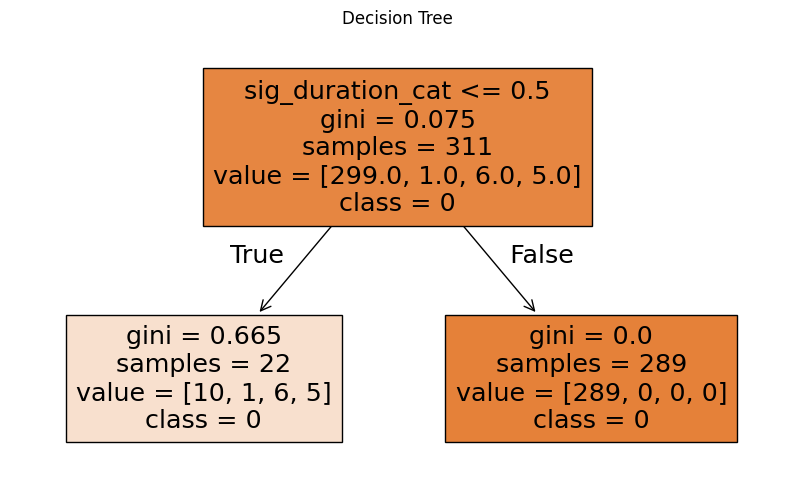

In [23]:
X = df[[root_feature]]
y = df['pga_cat']
clf = DecisionTreeClassifier()
clf.fit(X, y)

plt.figure(figsize=(10,6))
plot_tree(clf, feature_names=[root_feature], class_names=['0', '1', '2', '3'], filled=True)
plt.title("Decision Tree")
plt.show()

A7

c:\Users\Srijjay\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


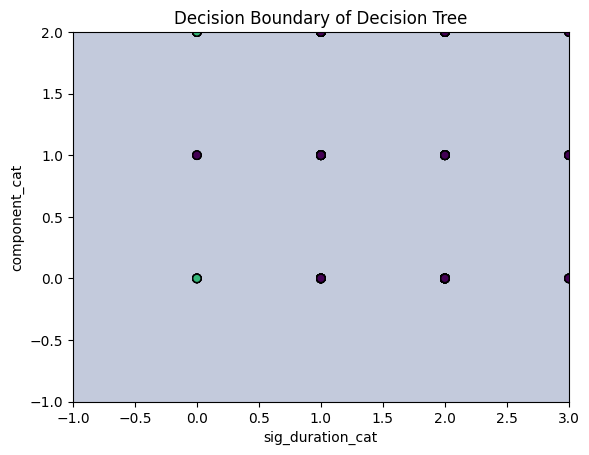

In [24]:
X = df[['sig_duration_cat', 'component_cat']]
y = df['pga_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)


x_min, x_max = X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1
y_min, y_max = X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors='k')
plt.xlabel('sig_duration_cat')
plt.ylabel('component_cat')
plt.title('Decision Boundary of Decision Tree')
plt.show()